In [1]:
pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import time
import numpy as np
np.random.seed(42)

In [3]:
from datasetsforecast.m4 import M4

In [4]:
group = 'Monthly'
await M4.async_download('data', group=group)

In [5]:
df, *_ = M4.load(directory='data', group=group)
n_series = len(np.unique(df.unique_id.values))

In [6]:
groups = np.random.choice(df["unique_id"].unique(), size=1000, replace=False)

In [7]:
df = df.set_index(["unique_id","ds"]).sort_index().groupby(level=0).tail(48)

df = df.loc[df.index.get_level_values('unique_id').isin(groups)].reset_index()

In [8]:
dates = pd.read_csv("data/m4/datasets/M4-info.csv")

In [9]:
dates["StartingDate"].str.len()

0        14
1        14
2        14
3        14
4        14
         ..
99995    14
99996    14
99997    14
99998    14
99999    14
Name: StartingDate, Length: 100000, dtype: int64

In [10]:
dates = (
    dates[ (dates["SP"]=="Monthly") & (dates["M4id"].isin(groups)) & (dates["StartingDate"].str.len()==14)]
        .assign(StartingDate = lambda x : pd.to_datetime(x["StartingDate"]))
        .loc[lambda df: df["StartingDate"]<'2020-01-01']#
        .rename(columns = {"M4id":"unique_id"})
)

/tmp/ipykernel_234203/2711033336.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .assign(StartingDate = lambda x : pd.to_datetime(x["StartingDate"]))


In [11]:
df = (
    df.set_index("unique_id")
        .join(dates[["unique_id","StartingDate"]].set_index("unique_id"))
        .rename(columns={"ds":"row"})
        .assign(
            ds = lambda x : pd.to_datetime((x["StartingDate"] + pd.to_timedelta(x["row"]*30, unit='D')).dt.date)
            )
        .reset_index()
)

In [12]:
df.dtypes

unique_id               object
row                      int64
y                      float64
StartingDate    datetime64[ns]
ds              datetime64[ns]
dtype: object

In [13]:
df["test"] = df["row"]>df.groupby("unique_id")["row"].transform(max)-3

/tmp/ipykernel_234203/2498131243.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df["test"] = df["row"]>df.groupby("unique_id")["row"].transform(max)-3


In [14]:
train = df[df["test"]==0].sort_values(by=["unique_id","ds"]).drop(columns=["test","row","StartingDate"])
test = df[df["test"]==1].sort_values(by=["unique_id","ds"]).drop(columns=["test","row","StartingDate"])

In [15]:
from statsforecast import StatsForecast
import time

/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from statsforecast.models import (
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS
)
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import DistributionLoss

2024-12-05 18:15:52,505	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-05 18:15:52,546	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [17]:
# Create a list of models and instantiation parameters
model_names = ["HistoricAverage","DynamicOptimizedTheta","SeasonalNaive","AutoARIMA","AutoETS","NBEATS"]

season_length = 12

models_classes_stats = [
    HistoricAverage(),
    DOT(season_length=season_length),
    SeasonalNaive(season_length=season_length),
    AutoARIMA(),
    AutoETS()
]

model_classes_neural = [
    NBEATS(h=3, input_size=10,
               stack_types = ['identity', 'trend', 'seasonality']
            )
]


INFO:lightning_fabric.utilities.seed:Seed set to 1


In [18]:
model_wrappers = []
model_wrappers = []

for model in model_classes_neural:
    model_wrappers.append(
        NeuralForecast( 
            models=[model],
            freq="M"
        )
    )    
    
for model in models_classes_stats:
    model_wrappers.append(
        StatsForecast( 
            models=[model],
            freq="M", 
            fallback_model = SeasonalNaive(season_length=12),
            n_jobs=-1,
        )
    )    


In [19]:
fit_times = []

for model in model_wrappers:
    print(model)
    start = time.time()
    model.fit(df=train)
    fit_times.append(time.time()-start)
    

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler 

Epoch 31:  25%|██▌       | 8/32 [00:00<00:00, 106.13it/s, v_num=17, train_loss_step=390.0, train_loss_epoch=341.0] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 31:  25%|██▌       | 8/32 [00:00<00:00, 105.19it/s, v_num=17, train_loss_step=390.0, train_loss_epoch=341.0]
StatsForecast(models=[HistoricAverage])
StatsForecast(models=[DynamicOptimizedTheta])
StatsForecast(models=[SeasonalNaive])
StatsForecast(models=[AutoARIMA])
StatsForecast(models=[AutoETS])


In [20]:
fit_times

[6.521298408508301,
 0.34830689430236816,
 15.339502811431885,
 0.35326719284057617,
 15.202961683273315,
 0.7005267143249512]

In [21]:
forecasts = []
forecast_times = []

for model in model_wrappers:

    start = time.time()

    if isinstance(model, NeuralForecast):
        forecasts.append(model.predict().reset_index())
    else:
        forecasts.append(model.predict(h=3))

    forecast_times.append(time.time()-start)


/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 32/32 [00:00<00:00, 693.83it/s]


/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq

In [22]:
train

,unique_id,y,ds
0,M10000,2740.0,2013-05-15
1,M10000,3000.0,2013-06-14
2,M10000,3040.0,2013-07-14
3,M10000,2920.0,2013-08-13
4,M10000,2870.0,2013-09-12
...,...,...,...
47992,M9964,700.0,2016-08-27
47993,M9964,630.0,2016-09-26
47994,M9964,630.0,2016-10-26
47995,M9964,610.0,2016-11-25


In [23]:
forecast_times

[0.09626007080078125,
 0.2944672107696533,
 4.826206922531128,
 0.38187074661254883,
 0.5406603813171387,
 0.31862473487854004]

In [24]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, rmse, rmsse
from functools import partial

metrics = [
    mape,
    rmse,
    partial(mase, seasonality=12),
    partial(rmsse, seasonality=12),
]

In [25]:
test

,unique_id,y,ds
45,M10000,2410.0,2017-01-24
46,M10000,2540.0,2017-02-23
47,M10000,2890.0,2017-03-25
93,M10127,1118.0,2016-07-09
94,M10127,1107.0,2016-08-08
...,...,...,...
47950,M9942,1480.0,2017-02-23
47951,M9942,1380.0,2017-03-25
47997,M9964,460.0,2017-01-24
47998,M9964,470.0,2017-02-23


In [26]:
test = test.set_index("unique_id")

for forecast in forecasts:
    print(forecast)
    test = pd.concat([test,forecast.drop(columns="ds").set_index("unique_id")],axis=1)

     unique_id         ds       NBEATS
0       M10000 2016-12-31  2312.993896
1       M10000 2017-01-31  2201.563477
2       M10000 2017-02-28  2072.066162
3       M10127 2016-06-30  1105.449219
4       M10127 2016-07-31  1106.429077
...        ...        ...          ...
2995     M9942 2017-01-31  1721.115479
2996     M9942 2017-02-28  1718.626343
2997     M9964 2016-12-31   504.776001
2998     M9964 2017-01-31   497.198578
2999     M9964 2017-02-28   511.440216

[3000 rows x 3 columns]
     unique_id         ds  HistoricAverage
0       M10000 2016-12-31      2496.444444
1       M10000 2017-01-31      2496.444444
2       M10000 2017-02-28      2496.444444
3       M10127 2016-06-30      1059.200000
4       M10127 2016-07-31      1059.200000
...        ...        ...              ...
2995     M9942 2017-01-31      2070.222222
2996     M9942 2017-02-28      2070.222222
2997     M9964 2016-12-31       822.888889
2998     M9964 2017-01-31       822.888889
2999     M9964 2017-02-28       82

In [27]:
test = test.reset_index()

In [28]:
eval = evaluate(test, metrics=metrics, train_df=train)

In [29]:
metrics = eval.set_index(["unique_id","metric"]).stack().rename_axis(index={None: 'Model'}).rename("value")

In [30]:
times = pd.DataFrame(
    {
        "Model":model_names,
        "fit_time":fit_times,
        "inference_time":forecast_times
    }
).set_index("Model")

In [31]:
metrics.groupby(level=[1,2]).median().unstack()

Model,AutoARIMA,AutoETS,DynamicOptimizedTheta,HistoricAverage,NBEATS,SeasonalNaive
metric,,,,,,
mape,0.039272,0.040562,0.037035,0.095473,0.038956,0.070072
mase,0.517773,0.501855,0.475772,1.347623,0.513992,0.917067
rmse,161.511496,164.476500,151.446931,414.833355,159.414102,280.888254
rmsse,0.474471,0.463602,0.445671,1.172506,0.475709,0.824101


In [32]:
md = metrics.groupby(level=[1,2]).mean().to_frame().join(times).set_index("value",append=True).stack().rename_axis(index={None: 'time'}).rename("time_value").reset_index()

In [33]:
import seaborn as sns

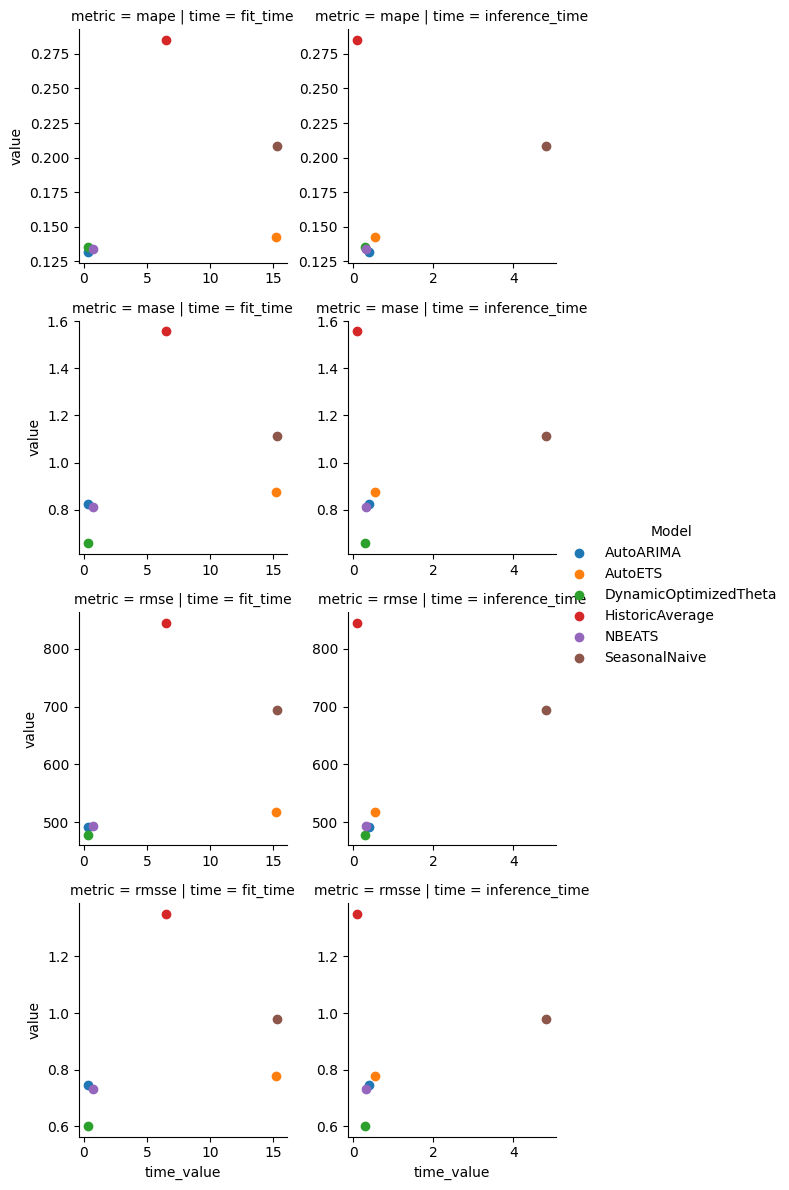

In [34]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(md, row= "metric", col="time", hue = "Model",sharey=False,sharex=False)
g = g.map(plt.scatter, "time_value", "value")
g.add_legend()